In [320]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

Функция для генерации выборки из нормального распределения с заданными параметрами

In [321]:
def normal_samples(n_size, mu=0, sigma=1):
    return norm.rvs(size=n_size, loc=mu, scale=sigma)
    

Класс для работы с моделью авторегрессии и скользящего среднего (ARMA)

In [322]:
class ARMA:
    def __init__(self, ar_size, ma_size):
        self._c = np.zeros(1)
        self._ar = np.zeros(ar_size)
        self._ma = np.zeros(ma_size)
        self._params = np.hstack([self._c, self._ar, self._ma])
        self._pq = (ar_size, ma_size)
    
    def read_coefficient_from_file(self, filename):
        with open(filename, 'r') as f:
            p, q = list(map(int, f.readline().split()))
            coeff = list(map(float, f.readline().split()))
            self._params = coeff
            self._c = coeff[0]
            self._ar = coeff[1: q + 1]
            self._ma = coeff[q + 1: ]
            self._pq = (p, q)
            
    def prepare_data(self, time_series, noise):
        X_data = None
        p, q = self._pq
        for k in range(n_size):
            free_const = np.array([1])
            y = np.array([time_series[k - i] if k - i >= 0 else 0 for i in range(1, p + 1)])
            nu = np.array([noise[k - i] if k - i >= 0 else 0 for i in range(q + 1)])
            current_row = np.hstack([free_const, y, nu])
            if X_data is None:
                X_data = current_row
            else:
                X_data = np.vstack([X_data, current_row])
            
        
        return X_data, time_series

    
    def generate_new_data(self, n_size):
        time_series, noise = self.generate_time_series(n_size)
        X_data = None
        p, q = self._pq
        for k in range(n_size):
            free_const = np.array([1])
            y = np.array([time_series[k - i] if k - i >= 0 else 0 for i in range(1, p + 1)])
            nu = np.array([noise[k - i] if k - i >= 0 else 0 for i in range(q + 1)])
            current_row = np.hstack([free_const, y, nu])
            if X_data is None:
                X_data = current_row
            else:
                X_data = np.vstack([X_data, current_row])
            
        
        return X_data, time_series, noise
    
    def generate_time_series(self, n_size):
        p, q = self._pq
        noise = normal_samples(n_size)
        time_series = np.zeros(n_size)
        time_series[0] = noise[0] + self._c
        for k in range(1, n_size):
            time_series[k] = noise[k] + self._c
            for i in range(1, p + 1):
                if p - i > 0:
                    time_series[k] += self._ar[i - 1] * time_series[k - i]
            for i in range(1, q + 1):
                if q - i > 0:
                    time_series[k] += self._ma[i - 1] * time_series[k - i]
        
        return time_series, noise

    def get_AR_params(self):
        return self._ar
    
    def get_MA_params(self):
        return self._ma
    
    def get_model_params(self):
        return self._params
    
    def get_pq(self):
        return self._pq

Метод наименьших квадратов

In [323]:
def least_square(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

Рекурсивный метод наименьших квадратов

In [324]:
def recursive_least_square(X, y):
    beta = 1500
    P = beta * np.eye(X.shape[1])
    theta = np.zeros(X.shape[1])
    theta_seq = np.zeros((X.shape[0], X.shape[1]))
    for i in range(X.shape[0]):
        P = P - (P @ np.outer(X[i], X[i])) @ P / (1 + ((X[i] @ P) @ X[i]))
        theta = theta + (P @ X[i]) * (y[i] - (X[i] @ theta))
        theta_seq[i] = theta
    return theta_seq

Функция для удаления константного признака (1 при $\beta_0$) из вектора оценки

In [325]:
def drop_const_feature(teta, p, q):
    return np.hstack([teta[: p + 1], teta[p + 2:]])

Сумма квадратов ошибок

In [326]:
def squared_error(y, y_pred):
    return np.sum((y - y_pred) ** 2)

Метрика качества $R^2$

In [327]:
def r2(y, y_pred):
    return 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)

Критерий Акайке

In [328]:
def aic(y, y_pred, count_params):
    result = len(y) * np.log(squared_error(y, y_pred)) + 2 * count_params
    return result

Для начала сгенерируем наш временной ряд содержащий 100 наблюдений

In [329]:
model = ARMA(3, 3)
model.read_coefficient_from_file('coeff.txt')
n_size = 1000
X_data, y, noise = model.generate_new_data(n_size)

Теперь обучимся на этих данных использую модели от ARMA(1, 1) до ARMA(3, 3) (всего 9 моделей) с помощью метода наименьших квадратов и рекурсивного метода наименьших квадратов

In [330]:
x_labels = []

se_ls_samples = []
r2_ls_samples = []
aikake_ls_samples = []
se_rls_samples = []
r2_rls_samples = []
aikake_rls_samples = []



for p_parametr in [1, 2, 3]:
    for q_parametr in [1, 2, 3]:
        current_model = ARMA(p_parametr, q_parametr)
        X_current, y_current = current_model.prepare_data(y, noise)
        teta_ls = least_square(X_current, y_current)
        teta_rls = recursive_least_square(X_current, y_current)[-1]
        
        #print(X_current.shape, teta_ls.shape)
        y_pred_ls = X_current @ teta_ls
        y_pred_rls = X_current @ teta_rls
        
        se_ls = squared_error(y, y_pred_ls)
        se_ls_samples.append(se_ls)
        r2_ls = r2(y, y_pred_ls)
        r2_ls_samples.append(r2_ls)
        aikake_ls = aic(y, y_pred_ls, p_parametr + q_parametr - 1)
        aikake_ls_samples.append(aikake_ls)
        
        se_rls = squared_error(y, y_pred_rls)
        se_rls_samples.append(se_rls)
        r2_rls = r2(y, y_pred_rls)
        r2_rls_samples.append(r2_rls)
        aikake_rls = aic(y, y_pred_rls, p_parametr + q_parametr - 1)
        aikake_rls_samples.append(aikake_rls)
        
        x_labels.append(f'ARMA({p_parametr}, {q_parametr})')
        print(f'ARMA({p_parametr}, {q_parametr})')
        print(f'Метод наименьших квадратов')
        print(f'squared error = {se_ls} r^2 = {r2_ls} aic = {aikake_ls}')
        print(f'Рекурсивный метод наименьших квадратов')
        print(f'squared error = {se_rls} r^2 = {r2_rls} aic = {aikake_rls}')

ARMA(1, 1)
Метод наименьших квадратов
squared error = 0.040318673582097384 r^2 = 0.9999849153028215 aic = -3208.940553029561
Рекурсивный метод наименьших квадратов
squared error = 0.04031867425237574 r^2 = 0.9999849153025708 aic = -3208.940536405047
ARMA(1, 2)
Метод наименьших квадратов
squared error = 0.0003010400534581408 r^2 = 0.9999998873698551 aic = -8104.267234100911
Рекурсивный метод наименьших квадратов
squared error = 0.00030104085096705987 r^2 = 0.9999998873695568 aic = -8104.264584925648
ARMA(1, 3)
Метод наименьших квадратов
squared error = 2.2674639440084703e-06 r^2 = 0.9999999991516584 aic = -12990.8485562926
Рекурсивный метод наименьших квадратов
squared error = 2.268433209680297e-06 r^2 = 0.9999999991512958 aic = -12990.421180779558
ARMA(2, 1)
Метод наименьших квадратов
squared error = 3.742177020807882e-24 r^2 = 1.0 aic = -53938.37469865488
Рекурсивный метод наименьших квадратов
squared error = 4.051939319467659e-08 r^2 = 0.9999999999848402 aic = -17017.48513313027
ARMA

Построим график зависимости squared error от модели

In [331]:
se_ls_samples

[0.040318673582097384,
 0.0003010400534581408,
 2.2674639440084703e-06,
 3.742177020807882e-24,
 2.1194378194634832e-19,
 2.4367830078853128e-15,
 66.82465512307087,
 8.052523317628648,
 111.52111529250132]

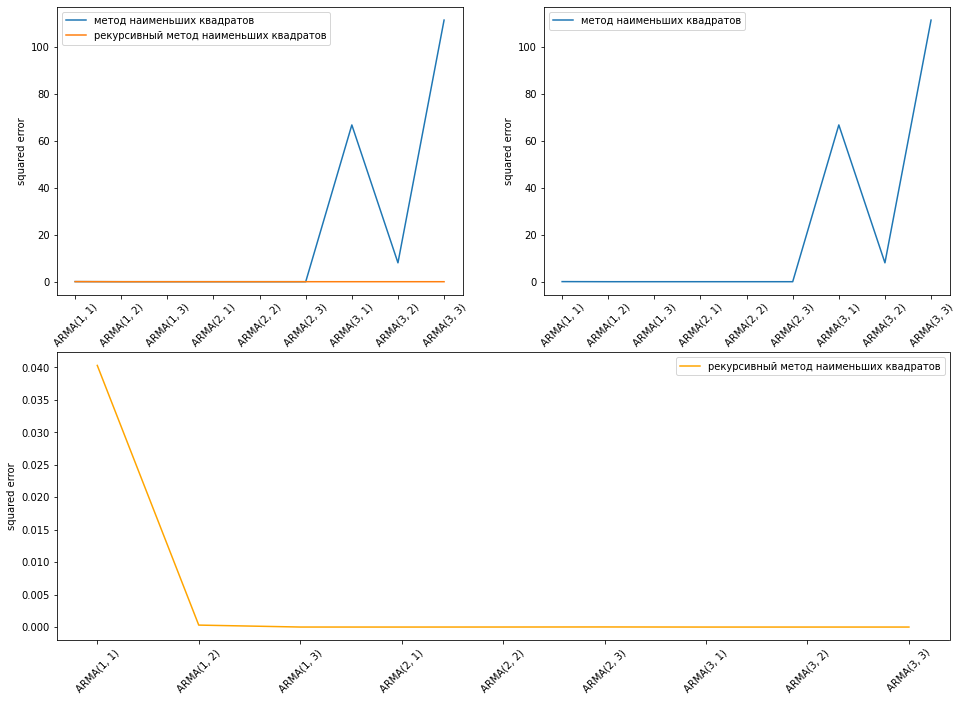

In [332]:
plt.figure(figsize=(16, 18))
plt.subplot(3, 2, 1)
plt.ylabel('squared error')
plt.xticks(np.arange(len(se_ls_samples)), x_labels, rotation=45)
plt.plot(se_ls_samples, label='метод наименьших квадратов')
plt.plot(se_rls_samples, label='рекурсивный метод наименьших квадратов')
plt.legend()
plt.subplot(3, 2, 2)
plt.xticks(np.arange(len(se_ls_samples)), x_labels, rotation=45)
plt.ylabel('squared error')
plt.plot(se_ls_samples, label='метод наименьших квадратов')
plt.legend()
plt.subplot(3, 1, 2)
plt.xticks(np.arange(len(se_ls_samples)), x_labels, rotation=45)
plt.ylabel('squared error')
plt.plot(se_rls_samples, label='рекурсивный метод наименьших квадратов', c='orange')
plt.legend();

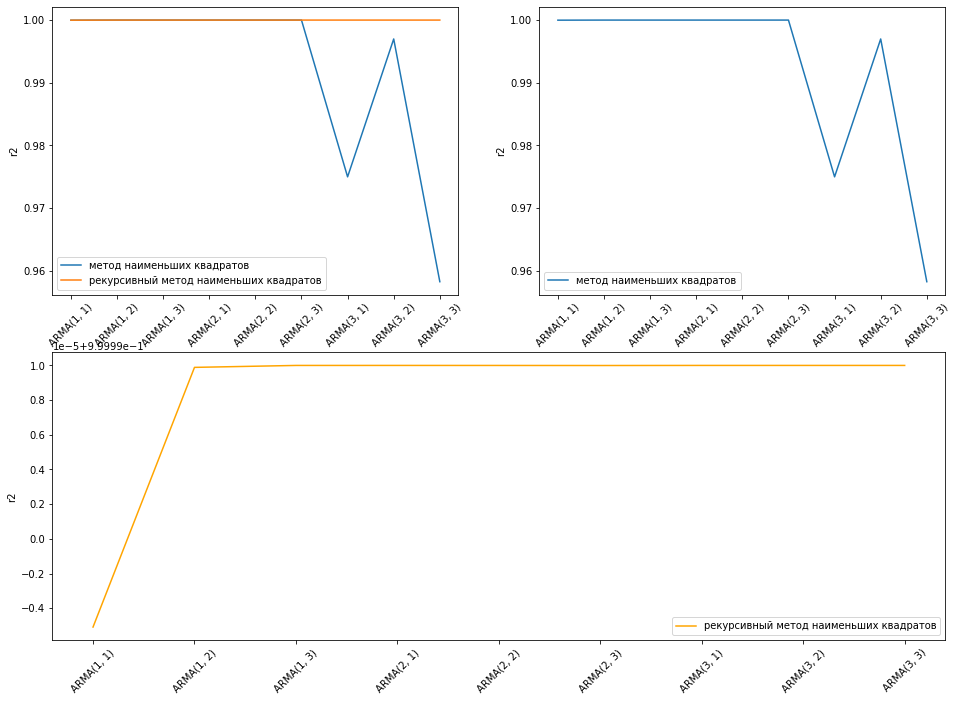

In [333]:
plt.figure(figsize=(16, 18))
plt.subplot(3, 2, 1)
plt.ylabel('r2')
plt.xticks(np.arange(len(r2_ls_samples)), x_labels, rotation=45)
plt.plot(r2_ls_samples, label='метод наименьших квадратов')
plt.plot(r2_rls_samples, label='рекурсивный метод наименьших квадратов')
plt.legend()
plt.subplot(3, 2, 2)
plt.xticks(np.arange(len(r2_ls_samples)), x_labels, rotation=45)
plt.ylabel('r2')
plt.plot(r2_ls_samples, label='метод наименьших квадратов')
plt.legend()
plt.subplot(3, 1, 2)
plt.xticks(np.arange(len(r2_ls_samples)), x_labels, rotation=45)
plt.ylabel('r2')
plt.plot(r2_rls_samples, label='рекурсивный метод наименьших квадратов', c='orange')
plt.legend();

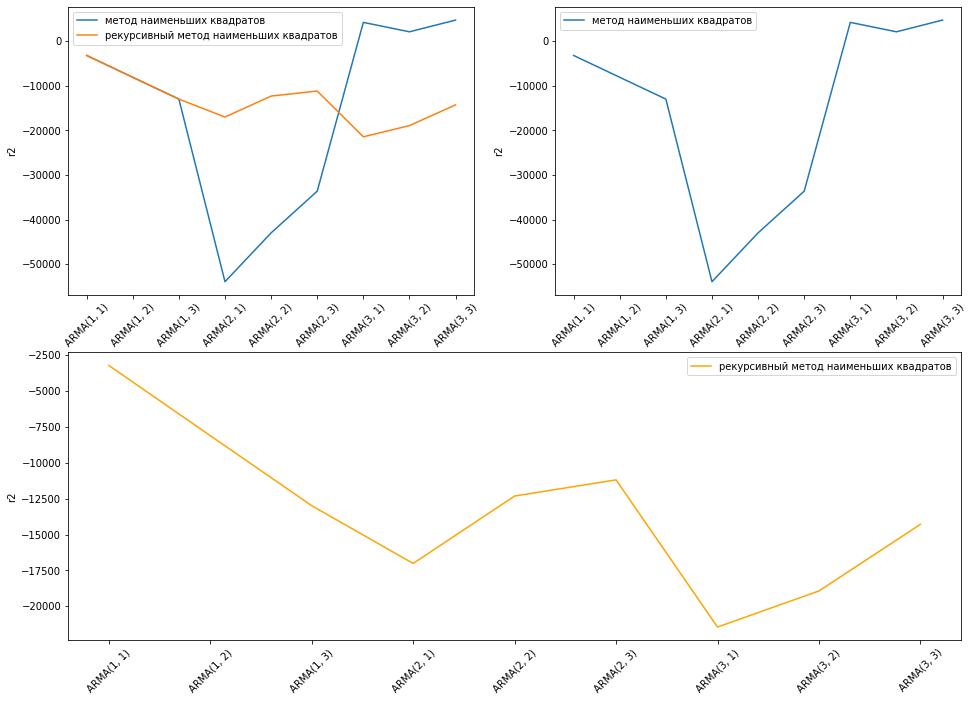

In [334]:
plt.figure(figsize=(16, 18))
plt.subplot(3, 2, 1)
plt.ylabel('r2')
plt.xticks(np.arange(len(r2_ls_samples)), x_labels, rotation=45)
plt.plot(aikake_ls_samples, label='метод наименьших квадратов')
plt.plot(aikake_rls_samples, label='рекурсивный метод наименьших квадратов')
plt.legend()
plt.subplot(3, 2, 2)
plt.xticks(np.arange(len(r2_ls_samples)), x_labels, rotation=45)
plt.ylabel('r2')
plt.plot(aikake_ls_samples, label='метод наименьших квадратов')
plt.legend()
plt.subplot(3, 1, 2)
plt.xticks(np.arange(len(r2_ls_samples)), x_labels, rotation=45)
plt.ylabel('r2')
plt.plot(aikake_rls_samples, label='рекурсивный метод наименьших квадратов', c='orange')
plt.legend();

Посмотрим как приближаются коеффициенты модели к настоящим значениям в зависимости от количества итераций

Сгенерируем новые данные

In [335]:
model = ARMA(3, 3)
model.read_coefficient_from_file('coeff.txt')
n_size = 1000
X_data, y, noise = model.generate_new_data(n_size)

Рассмотрим параметр $a_0$

Посмотрим чему равен $a_0$

In [336]:
a0 = model.get_model_params()[0]
print(a0)

0.0


In [337]:
current_model = ARMA(3, 3)
X_current, y_current = current_model.prepare_data(y, noise)
teta_ls = least_square(X_current, y_current)
teta_rls_iterations = recursive_least_square(X_current, y_current)



Построим график распределение параметра $a_0$

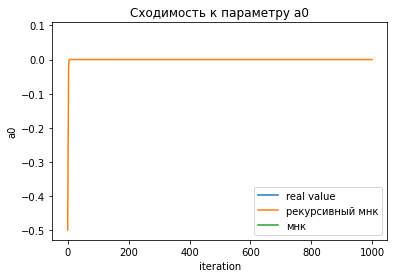

In [338]:
plt.title('Сходимость к параметру a0')
plt.ylabel('a0')
plt.xlabel('iteration')
plt.plot(np.arange(2), [a0, a0], label='real value')
plt.plot(teta_rls_iterations[:, 0], label='рекурсивный мнк')
plt.plot(teta_ls[0], label='мнк')
plt.legend();

Теперь посмотрим на параметр $b_2$

In [339]:
print(model.get_model_params()[5])

0.25


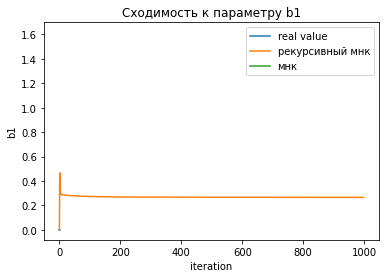

In [340]:
plt.title('Сходимость к параметру b1')
plt.ylabel('b1')
plt.xlabel('iteration')
plt.plot(np.arange(2), [a0, a0], label='real value')
plt.plot(teta_rls_iterations[:, 5], label='рекурсивный мнк')
plt.plot(teta_ls[5], label='мнк')
plt.legend();